In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
DATASET_PATH = '/content/drive/MyDrive/Crema'  # <-- adjust if needed


Mounted at /content/drive


In [2]:
!pip install transformers torchaudio librosa scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [11]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Emotion code to label mapping
emotion_map = {
    'ANG': 'Anger',
    'DIS': 'Disgust',
    'FEA': 'Fear',
    'HAP': 'Happy',
    'NEU': 'Neutral',
    'SAD': 'Sad'
}

# Scan folder and build dataset
files = []
for fname in os.listdir(DATASET_PATH):
    if fname.endswith('.wav'):
        parts = fname.split('_')
        if len(parts) >= 3 and parts[2] in emotion_map:
            files.append((os.path.join(DATASET_PATH, fname), emotion_map[parts[2]]))

df = pd.DataFrame(files, columns=['filepath', 'emotion'])

# Sample balanced subset (~300 per class)
df_balanced = df.groupby('emotion').apply(lambda x: x.sample(1000, random_state=42)).reset_index(drop=True)

# Train-test split
train_df, test_df = train_test_split(df_balanced, stratify=df_balanced['emotion'], test_size=0.2, random_state=42)


<ipython-input-11-4d24a34a1b66>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('emotion').apply(lambda x: x.sample(1000, random_state=42)).reset_index(drop=True)


In [12]:
# Restart runtime first (from Runtime > Restart Runtime), then run:
!rm -rf facebook__* hubert-base-ls960/ hubert-base-ls960


In [13]:
import torch
import torchaudio
from torch.utils.data import Dataset

resampler = torchaudio.transforms.Resample(orig_freq=44100, new_freq=16000)
label_map = {label: idx for idx, label in enumerate(df_balanced['emotion'].unique())}

class CREMADataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        waveform, sr = torchaudio.load(row['filepath'])

        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        if sr != 16000:
            waveform = resampler(waveform)

        waveform = waveform[:, :48000]  # Trim/pad to 3s max
        if waveform.shape[1] < 48000:
            pad_len = 48000 - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, pad_len))

        label = label_map[row['emotion']]
        return waveform.squeeze(0), waveform.unsqueeze(0), torch.tensor(label)


In [14]:
import torch.nn as nn
from transformers import HubertModel

class CNNHuBERTClassifier(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.hubert = HubertModel.from_pretrained("facebook/hubert-base-ls960")
        for param in self.hubert.parameters():
            param.requires_grad = False  # freeze HuBERT

        self.hubert_fc = nn.Linear(768, 128)

        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, 5, stride=2),
            nn.ReLU(),
            nn.Conv1d(16, 32, 5, stride=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(32)
        )
        self.cnn_fc = nn.Linear(32 * 32, 128)

        self.classifier = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, audio_input, cnn_input):
        with torch.no_grad():
            hubert_out = self.hubert(audio_input).last_hidden_state.mean(dim=1)
        hubert_feat = self.hubert_fc(hubert_out)

        cnn_out = self.cnn(cnn_input)
        cnn_feat = self.cnn_fc(cnn_out.view(cnn_out.size(0), -1))

        combined = torch.cat((hubert_feat, cnn_feat), dim=1)
        return self.classifier(combined)



In [15]:
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNHuBERTClassifier(num_classes=6).to(device)

train_loader = DataLoader(CREMADataset(train_df), batch_size=8, shuffle=True)
test_loader = DataLoader(CREMADataset(test_df), batch_size=8)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    model.train()
    total_loss = 0
    for hubert_input, cnn_input, labels in train_loader:
        hubert_input = hubert_input.to(device)
        cnn_input = cnn_input.to(device).squeeze(2)  # Fix: [B, 1, 48000]
        labels = labels.to(device)

        outputs = model(hubert_input, cnn_input)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")




Epoch 1 Loss: 1.6677
Epoch 2 Loss: 1.4624
Epoch 3 Loss: 1.3660
Epoch 4 Loss: 1.2936
Epoch 5 Loss: 1.2405
Epoch 6 Loss: 1.1992
Epoch 7 Loss: 1.1573
Epoch 8 Loss: 1.1302
Epoch 9 Loss: 1.1161
Epoch 10 Loss: 1.0930


In [16]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for hubert_input, cnn_input, labels in test_loader:
        hubert_input = hubert_input.to(device)
        cnn_input = cnn_input.to(device)
        labels = labels.to(device)

        outputs = model(hubert_input, cnn_input.squeeze(2))

        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import accuracy_score, classification_report
acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {acc * 100:.2f}%")
print("\nClassification Report:\n", classification_report(all_labels, all_preds))



Test Accuracy: 60.58%

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.85      0.73       200
           1       0.59      0.53      0.56       200
           2       0.72      0.38      0.50       200
           3       0.61      0.53      0.57       200
           4       0.52      0.88      0.65       200
           5       0.68      0.47      0.56       200

    accuracy                           0.61      1200
   macro avg       0.63      0.61      0.59      1200
weighted avg       0.63      0.61      0.59      1200



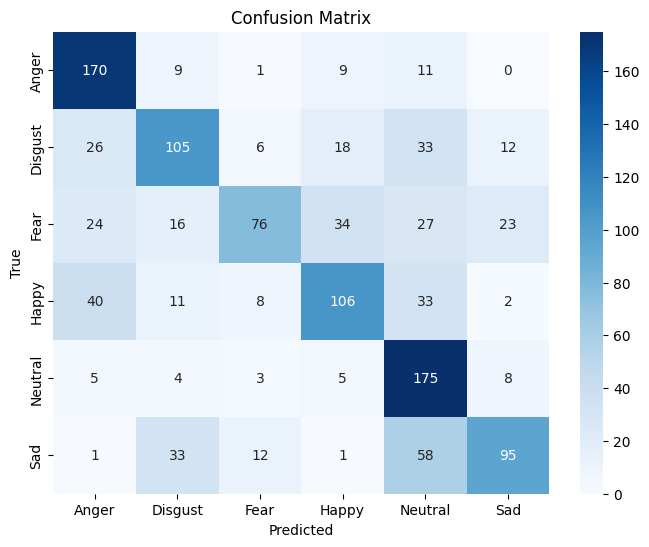

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
emotion_labels = list(label_map.keys())

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
